Accompanied with Stone et al. (2022), how to utilize the package to create temperature profile maps of AGN accretion disks using spectroscopic/photometric light curve data.

First, we will need to import the necessary packages, as well as the package itself. All required packages are located in "requirements.txt"

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numba_progress import ProgressBar
from numba import njit

import astropy.constants as const
import astropy.units as u
from astropy.table import Table
import awkward as ak
from scipy.sparse import csc_matrix

from tqdm import tqdm

In [2]:
import temp_map.utils as utils
import temp_map.algorithm as alg
import temp_map.plotting as tpplot
import temp_map.input as tpin
import temp_map.run as run

These are just parameters to make the plots look nice (to me at least)

In [3]:
import matplotlib as mpl

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams["figure.autolayout"] = False

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams["axes.axisbelow"] = False

We'll use multi-band light curve data from NGC5548, with a different cadence for each band. This is the same data used in NK22, sampled in the observed frame. We have already applied the error "triplet test" as described in NK22 as well, as the error for NGC5548 is too low for the algorithm.

In [4]:
output = np.load('NGC5548_Data.npz', allow_pickle=True)

lambda_vals = np.array(output['wavelength'])*1e-8 #in cm
td_input = np.array(output['dates'])
flux_input = np.array(output['flux'])
err_input = np.array(output['error'])

filters = np.array(output['filters'])

Here are the AGN parameters for NGC5548:

In [5]:
AGN_params = dict(obj_name='NGC5548',
                  z = .017,
                  dist = 75 * 1e6 * u.pc.to(u.cm),
                  MBH = (10**7.505) * u.solMass.to(u.g),
                  lambda_edd = .1)

We assume $\alpha = 6$ and $i = 30^o$

In [6]:
AGN_params['alpha'] = 6
AGN_params['inc'] = 30*np.pi/180

Now we redshift correct the times, fluxes, and wavelengths into the quasar rest frame, for each band:

In [7]:
#The flux, error, and dates have NaNs in them to make the length of each light curve the same
#Remove NaNs
td_vals = []
flux_dat = []
err_dat = []
for i in range(len(td_input)):
    nan_mask = np.isnan(td_input[i])
    
    td_vals.append( td_input[i][~nan_mask] )
    flux_dat.append( flux_input[i][~nan_mask] )
    err_dat.append( err_input[i][~nan_mask] )
    
    
#Get minimum td
min_vals = []
for i in range(len(td_vals)):
    min_vals.append( np.min(td_vals[i]) )
    
min_td = np.min(min_vals)
    
    
#Redshift correct
lc_lengths = []
for i in range(len(td_vals)):
    td_vals[i] = ( np.array(td_vals[i]) - min_td )/ (1 + AGN_params['z'])
    
    flux_dat[i] = np.array(flux_dat[i]) * (1 + AGN_params['z'])**2
    err_dat[i] = np.array(err_dat[i]) * (1 + AGN_params['z'])**2
    
    lc_lengths.append( len(td_vals[i]) )
    
lambda_vals /= (1 + AGN_params['z'])
    
    
#Flatten arrays
td_vals_flat = np.zeros( np.sum(lc_lengths).astype(int) )
flux_dat_flat = np.zeros( np.sum(lc_lengths).astype(int) )
err_dat_flat = np.zeros( np.sum(lc_lengths).astype(int) )

for i in range(len(lc_lengths)):
    ind1 = np.sum(lc_lengths[:i]).astype(int)
    ind2 = ind1 + lc_lengths[i]
    
    td_vals_flat[ind1:ind2] = td_vals[i]
    flux_dat_flat[ind1:ind2] = flux_dat[i]
    err_dat_flat[ind1:ind2] = err_dat[i]

Now, we have the input light curves with error, but in terms of the absolute flux $F_\lambda$. We need the input to be the flux perturbations $\delta F_\lambda$, so we'll need to subtract the mean light curve to approximate it. We'll subtract the mean light curve from each band:

In [8]:
dF_dat = np.zeros_like( td_vals_flat )
mean_lcs = []
for i in range(len(lc_lengths)):
    ind1 = np.sum(lc_lengths[:i]).astype(int)
    ind2 = ind1 + lc_lengths[i]
    
    mean_lc = np.mean(flux_dat_flat[ind1:ind2])
    var_lc = np.var(flux_dat_flat[ind1:ind2])
    
    dF_dat[ind1:ind2] = flux_dat_flat[ind1:ind2] - mean_lc
    mean_lcs.append(mean_lc)
    

Now that we have the processed input light curves, we need to construct the grids for each parameter used in the inversion. We construct the $t_p$ array to start a few days before the first observation, and end a few days after the last observation.

In [9]:
N_tp = 100
tp_vals, dt = np.linspace( np.min(td_vals_flat)-2, np.max(td_vals_flat)+2, N_tp, retstep=True, dtype=float)

To construct the $u$ array, we need to determine the range of radii probed by the spectroscopic data. This involves both the parameters of the AGN, and the range of $\lambda$ observed in the data. 

Luckily, there is a convenient function in "utils" to show us the range of relevant radii and output the range we need.

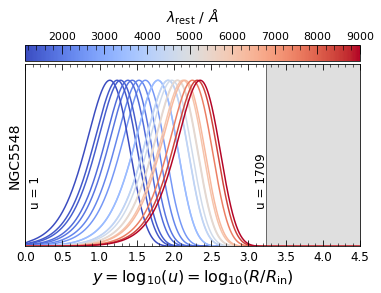

In [10]:
ymin, ymax, ymin2, ymax2 = utils.get_filter_kernels(lambda_vals, AGN_params, plot=True)

This shows the filter kernels (like in NK22) for each wavelength. The output values are in terms of $y = \log_{10}(u)$, which we'll be working in for the rest of the analysis.

We'll sample the radii evenly in $y$, between $y_{min}$ and $y_{max}$. 

In [11]:
Nu = 50
yvals, dy = np.linspace(ymin, ymax, Nu, retstep=True)

## Using the algorithm

Now that we have the input spectra and temperature map, we can start constructing the $W_\sigma$ matrix for the inversion. There is a function in "algorithm" that can construct this matrix for us, with a number of options (many similar to the function to construct $F_\lambda$).

The data aren't sampled at the same cadence for each light curve, so forming the $W$ matrix won't be as simple. We need to format the input data arrays properly for an arbitrarily sampled dataset. The y-grid and $t_p$-grid are unchanged, as they don't depend on the samples of data.

The $t_d$ array is in the right format, but the $\lambda$ array isn't. We need an array of lambda that corresponds to each observation in the $t_d$ array:

In [12]:
N_td = len(td_vals_flat)

lambda_vals_input = np.zeros( N_td )
for i in range(len(lc_lengths)):
    ind1 = np.sum(lc_lengths[:i]).astype(int)
    ind2 = ind1 + lc_lengths[i]
    
    lambda_vals_input[ind1:ind2] = lambda_vals[i]

The $W_\sigma$ matrix will lilely be very large ($N_{t_d}$ x $N_u N_{t_p}$), so we will use a SciPy sparse CSC matrix to construct it. This requires an array for the column, row, and value of each nonzero element in the matrix.

However, there is a caveat: this is a numba function, which is very particular about what classes and functions can be used within it. For example, numba functions do not like python lists to be appended. So, we will need to use an Awkward array to construct the CSC sparse matrix arrays. These arrays are then used as inputs to the function, filled, and then output.

After we have these Awkward arrays, we need to turn them into arrays that can be accessed by other functions, so we get a "snapshot" of each of them. There is then a function (chunk_fill) to chunk-in the CSC matrix, which tracks how much of the matrix has been filled with a progress bar. It fills in the matrix in chunks of data, one chunk at a time (which is specified in one of the arguments).

This chunk filling function also requires the shape of the array, which would normally be $N_{t_d}$ x $N_u N_{t_p}$. However, we include an additional parameter per wavelength to account for the difference in the model steady-state and the mean input spectrum. So, we use a shape of $N_{t_d}$ x ($N_u N_{t_p} + N_{\rm lc}$).

In [13]:
row_dat = ak.ArrayBuilder()
col_dat = ak.ArrayBuilder()
input_dat = ak.ArrayBuilder()

with ProgressBar(total=Nu*N_tp*N_td) as progress:
    rows, cols, inputs = alg.make_W_arbitrary(row_dat, col_dat, input_dat, yvals, tp_vals, 
                                              td_vals_flat, lambda_vals_input,
                                              AGN_params['lambda_edd'], 
                                              AGN_params['MBH'], 
                                              AGN_params['dist'], 
                                              AGN_params['inc'], 
                                              alpha=AGN_params['alpha'], 
                                              progress_hook=progress,
                                              errs=err_dat_flat, dat_type='dToT', 
                                              include_F0=True)

row_snap = rows.snapshot()
col_snap = cols.snapshot()
dat_snap = inputs.snapshot()

W_matrix = utils.chunk_fill(row_snap, col_snap, dat_snap, shape=( N_td, Nu*N_tp + len(lc_lengths) ), Nchunk=int(1e4) )

  3%|▎         | 863708.0/29500000 [00:43<24:05, 19810.59it/s]


Now that we have $W_\sigma$, we can construct the other relevant matrices for the inversion: $W_\sigma^T W_\sigma$, $I$, $D_k$, $D_l$.

It should be noted: we are working in terms of $\delta T / T$, **NOT** $\delta T$ (this was an option in the construction of the $W_\sigma$ matrix with "dat_type").

In NK22, they use $I_T$, $D_{kT}$, and $D_{lT}$, which are matrices divided by the steady-state temperature profile $T_0$. We include $T_0$ in the map we solve for, so we don't need to include it in all of these smoothing matrices and $W_\sigma$. This can be changed in the formation of $W_\sigma$.

There are functions to form the smoothing matrices, but only if we are working in terms of $\delta T / T$. This requires the size (of one side) of $W_\sigma^T W_\sigma$ and the size of the $u$ and $t_p$ arrays. To get these matrices when working in terms of $\delta T$, you would have to manually divide elements by the temperature as described in NK22.

In [14]:
WTW = W_matrix.transpose().dot( W_matrix )
size = WTW.shape[0]

I, Dk, Dl = alg.make_smoothing_matrices(Nu, N_tp, size)

We can now construct the right hand side of the equation: $W_\sigma^T \delta F_\sigma$

In [15]:
RHS = W_matrix.transpose() @ (dF_dat/err_dat_flat)
RHS = csc_matrix(RHS).transpose()

Next, we use the inversion formula specified in the paper:
$\delta T = [W_\sigma^T W_\sigma + \xi(I + D_k + D_l)] W_\sigma^T \delta F_\sigma$

To do this, we need to choose smoothing factors $\xi$ to use. I'll pick the usual values: 1, 10, 100, 1000.
I've also made a function that parallelizes the inversion with numba - this isn't needed but speeds upt the process. Each smoothing factor will have an output temperature profile map, which I'll put into an array **inv_outputs**.

In [16]:
@njit(parallel=True)
def fast_res(A, b):
    return np.linalg.inv(A) @ b

xi_vals = [1,10,100,1000]

inv_outputs = []
for xi in tqdm(xi_vals):
    A = csc_matrix( WTW + xi*(I + Dk + Dl) )

    res = fast_res(A.todense(), RHS.todense())
    res = np.array(res).T[0]

    inv_outputs.append( res )

100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


## Constructing and plotting the output

We have the output maps now, but they are in their flattened form, so we need to reshape them to be a 2D array like we had before. We'll place all of the reshaped arrays in an array labeled **dToT_outputs_reshape**.

In [17]:
dToT_outputs_reshape = []

for n in range(len(inv_outputs)):
    dToT_output_reshape = np.zeros((Nu, N_tp))
    for i in range(Nu*N_tp):
        dToT_output_reshape[ i%Nu, i//Nu ] = inv_outputs[n][i]
        
    dToT_outputs_reshape.append(dToT_output_reshape)

We can't plot the results yet because we need the $\chi^2$ values to display on the plot. To get these values, we'll need to construct the output spectra from the output temperature maps to compare to the input spectra. 

We can do this using the simple formula from the paper:
$\delta F_\sigma = W_\sigma \cdot \delta T$

We can also get the extra parameters used in the inversion as additive offsets between the model and data mean spectrum, one per wavelength. It should be noted that this gives us the output spectra **relative to the error** $\delta F_\sigma$, so we need to multiply by the error of the input spectra.

In [18]:
new_lc = []
for i in range(len(inv_outputs)):
    out = np.array( (W_matrix @ inv_outputs[i]) )
    new_lc.append( out * err_dat_flat )

offsets = []
for i in range(len(inv_outputs)):
    offsets.append( inv_outputs[i][Nu*N_tp:]  )

Next, we need to normalize the output light curves so they match the input light curves. Each light curve (i.e. wavelength) has an offset fitted by the algorithm, but still needs a multiplicative factor to normalize it to the input light curve. We can obtain this factor by minimizing $\chi^2$ and using the fitted offsets.


Let $\delta F_{in}(\lambda, t_d) = m(\xi, \lambda) \delta F_{out}(\xi, \lambda, t_d) + {\rm offsets} (\xi, \lambda)$

Minimizing $\chi^2$:  
$S_{xy} = \sum \frac{\delta F_{in}   \delta F_{out}}{\sigma^2}$  
$S_{x2} = \sum \frac{\delta F_{out} }{\sigma^2}$  
$S_x = \sum \frac{\delta F_{out}}{\sigma^2}$  
  
$m(\xi, \lambda) = \frac{S_{xy} - {\rm offsets}(\xi, \lambda) S_x }{S_{x2}}$


In [19]:
#Values are very small, so we use a fluff factor
FLUFF = 1e9 

m_coefs = np.zeros( ( len(xi_vals), len(lc_lengths) ) )

for i in range(len(xi_vals)):
    for j in range(len(lc_lengths)):
        ind1 = np.sum(lc_lengths[:j]).astype(int)
        ind2 = ind1 + lc_lengths[j]
        
        lc_in = dF_dat[ind1:ind2]*FLUFF
        lc_err = err_dat_flat[ind1:ind2]*FLUFF
        lc_out = new_lc[i][ind1:ind2]

        sxy = np.sum(lc_out*lc_in / lc_err**2)
        sx2 = np.sum(lc_out**2 / lc_err**2)
        sx = np.sum(lc_out / lc_err**2)

        m_coefs[i,j] = (sxy - offsets[i][j]*sx)/sx2 

Now that we have the multiplicative factors $m(\xi, \lambda)$, we can normalize the output spectra, and get the $\chi^2$ per data point ($\chi^2_\nu$) for each temperature map.

In [20]:
fitted_lc = np.zeros( ( len(xi_vals), N_td ) )

chi2_tot = []
for i in range(len(xi_vals)):
    chi2_tot.append([])

for a in tqdm( range(len(lc_lengths)) ):
    ind1 = np.sum(lc_lengths[:a]).astype(int)
    ind2 = ind1 + lc_lengths[a]


    lc_in = dF_dat[ind1:ind2]
    lc_err = err_dat_flat[ind1:ind2]

    for i in range(len(xi_vals)):
        lc_out = (m_coefs[i,a]* new_lc[i][ind1:ind2] + offsets[i][a])/FLUFF
        fitted_lc[i,ind1:ind2] = lc_out
        
        chi2 = np.sum( (lc_in - lc_out)**2 /lc_err**2  )/lc_lengths[a]
        chi2_tot[i].append(chi2)

chi2_tot = np.mean(chi2_tot, axis=1)        

100%|██████████| 19/19 [00:00<00:00, 5105.50it/s]


Now that we have $\chi^2_\nu$, we can plot the output temperature maps. There is a function to output the temperature maps and the input temperature map. Each temperature map will have a scale it is divided by, which is by default the 99 $^{th}$ percentile of the absolute value of the map, but this number can be changed.

This function takes multiple optional arguments:
- **fname**: the name of the file to save the plot to. If **None**, the plot will not be saved.
- **show**: whether to show the plot. If **False**, the plot will not be shown and the figure will be an output of the function.
- **interpolation**: the interpolation method to use when plotting the temperature maps.
- **percent**: the percentile of the absolute value of the data in the map to use as the scale.
- **date_type**: can either be **rest** or **obs** depending on the frame of the time values used

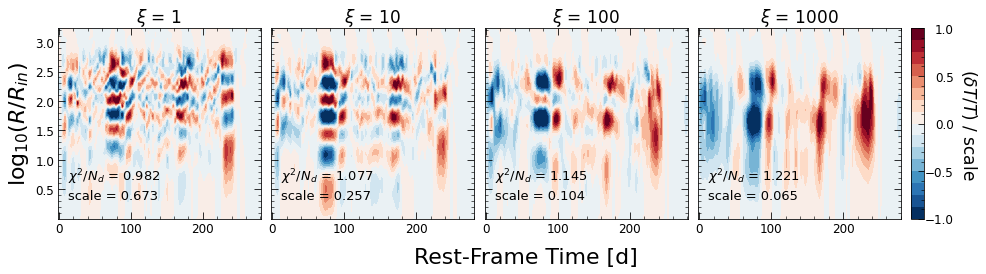

In [21]:
tpplot.plot_profs_out(dToT_outputs_reshape, tp_vals, 
                              yvals, xi_vals, chi2_tot,
                              fname=None, show=True, cmap_num=16,
                              interpolation='gaussian', date_type='rest')

We can also plot the output light curves against the input light curves (for each $\xi$) for each band $\lambda$ in an animation, and save the animation to a file. We specify the type of data ('lc' for light curves or 'spec' for spectra) for light curves, but this can also be done for arbitrarily sampled spectra.

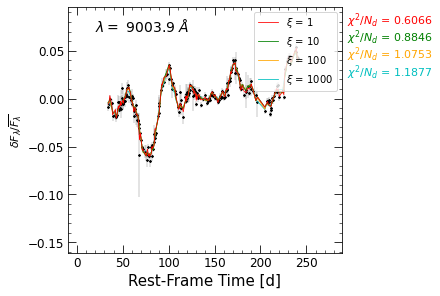

In [81]:
lc_fname = 'OutputLC.gif'
tpplot.animate_arbitrary_data(lc_lengths, fitted_lc, dF_dat, err_dat_flat, 
                           mean_lcs, td_vals_flat, lambda_vals_input, 
                           xi_vals, lc_fname, dat_type='lc', fps=.5)

We can also save all data to a numpy file for later use. And that's all!